In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(42);

In [3]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

GPU: Tesla T4 is available.
cuda


In [4]:
# Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

BATCH_SIZE = 4
EPOCHS = 2

In [5]:
def load_data(data):
  return torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [6]:
# import data
train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainLoader, testLoader = load_data(train), load_data(test)

classes = list(range(0,10))

trainLoader.dataset, len(classes)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=0.5, std=0.5)
            ),
 10)

In [7]:
iter_ = iter(trainLoader)
img_, cls_ = next(iter_)

img_.shape, cls_

(torch.Size([4, 1, 28, 28]), tensor([1, 2, 8, 5]))

tensor(1)


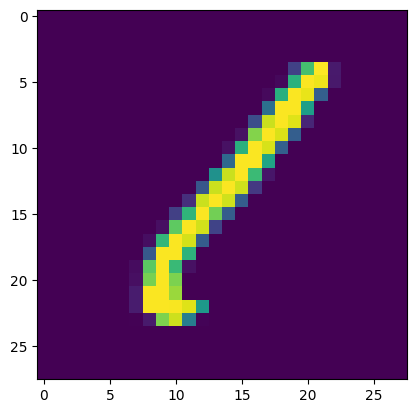

tensor(2)


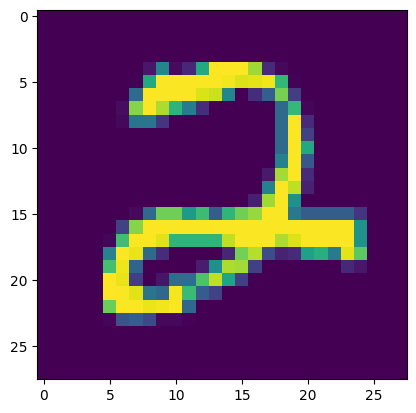

tensor(8)


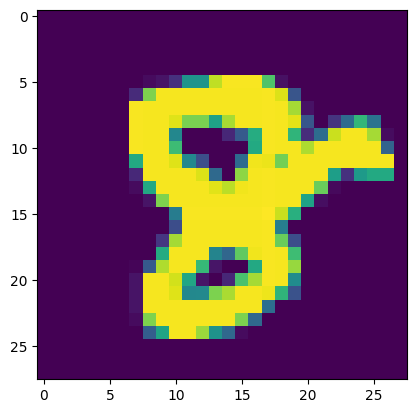

tensor(5)


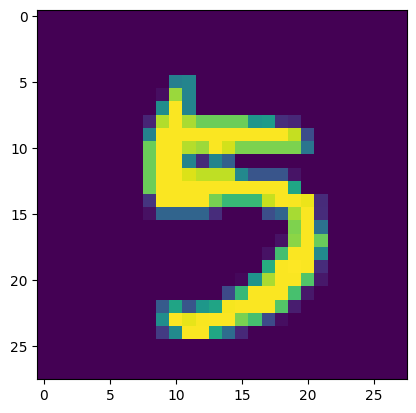

In [8]:
def img_show(img):
  plt.imshow(img.reshape(28, 28))
  plt.show()

for i in range(BATCH_SIZE):
  print(cls_[i])
  img_show(img_[i])

In [9]:
# Model
import torch.nn as nn
import torch.nn.functional as f

class CustomModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()
    self.input = nn.Linear(28*28, 128)
    self.hid_1 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 10)

  def forward(self, x):
    o_1 = self.relu(self.input(self.flatten(x)))
    o_2 = self.relu(self.hid_1(o_1))
    return self.output(o_2)

In [10]:
nn_ = CustomModel()
nn_.to(device)
nn_

CustomModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (input): Linear(in_features=784, out_features=128, bias=True)
  (hid_1): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
import torch.optim as optim

optimizer = optim.SGD(nn_.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [12]:
from torch.nn.functional import softmax

for epoch in range(EPOCHS):
  rloss = 0
  for i, data in enumerate(trainLoader):
    img, cls = data

    optimizer.zero_grad()

    logits = nn_(img.to(device))
    logits.to(device)
    #print(f"Outputs for iter {i}: ", logits)
    loss = loss_fn(logits, cls.to(device))

    loss.backward()
    optimizer.step()

    rloss += loss.item()

    if i % 2000 == 1999:    # print every 2000 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {rloss / 2000:.3f}')
        rloss = 0.0

[1,  2000] loss: 0.797
[1,  4000] loss: 0.374
[1,  6000] loss: 0.324
[1,  8000] loss: 0.260
[1, 10000] loss: 0.264
[1, 12000] loss: 0.231
[1, 14000] loss: 0.200
[2,  2000] loss: 0.176
[2,  4000] loss: 0.166
[2,  6000] loss: 0.156
[2,  8000] loss: 0.156
[2, 10000] loss: 0.142
[2, 12000] loss: 0.135
[2, 14000] loss: 0.141


In [29]:
correct = 0
total = 0
incorrect = {}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testLoader:
        img_, cls_ = data
        img_ = img_.to(device)
        cls_ = cls_.to(device)
        # calculate outputs by running images through the network
        outputs = nn_(img_)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += cls_.size(0)
        correct += (predicted == cls_).sum().item()

        for i, p in enumerate(predicted):
          if p == cls_[i]:
            continue

          try:
            incorrect[p.item()] += 1
          except:
            incorrect[p.item()] = 1
          #img_show(img_[i].to("cpu"))

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 96 %


In [32]:
incorrect

{2: 32, 8: 52, 9: 69, 7: 62, 0: 19, 1: 9, 5: 24, 3: 14, 4: 36, 6: 44}

In [30]:
sum = 0
for v in list(incorrect.values()):
  sum += v
sum

361

In [31]:
testLoader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )